<a href="https://colab.research.google.com/github/JazJaz426/Agent-based-Modeling-of-a-Zombie-Apocalypse/blob/master/assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## COMP5328 - Advanced Machine Learning
## Assignment 1: Non-negative Matrix Factorization
----------------------------------------------------------------------------------------
Authors: 
- Mai Le, male6657@uni.sydney.edu.au, 480398998
- Jiaming (Jazlyn) Lin, jlin0701@uni.sydney.edu.au, 470345744
- Yucheng Sun, ysun8114@uni.sydney.edu.au, 480341433

Tutors: 
- Songhua Wu
- Yu Yao

## 0 Colab Setting

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:

! ls

drive  sample_data


In [ ]:
%cd /content/drive/MyDrive/comp5238-a1/

/content/drive/MyDrive/comp5238-a1


## 1 Load Dataset

### 1.0 Data Folder

### 1.1 Load ORL Dataset and Extended YaleB Dataset.
+ ORL dataset contains ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). The size of each image is 92x112 pixels, with 256 grey levels per pixel. To further reduce the computation complexity, you can resize all images to 30x37 pixels.

+ Extended YaleB dataset contains 2414 images of 38 human subjects under 9 poses and 64 illumination conditions. All images are manually aligned, cropped, and then resized to 168x192 pixels. To further reduce the computation complexity, you can resize all images to 42x48 pixels.

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict
import numpy as np
import scipy.stats as stats


def load_data(root='data/CroppedYaleB', reduce=4):
    """ 
    Load ORL (or Extended YaleB) dataset to numpy array.
    
    Args:
        root: path to dataset.
        reduce: scale factor for zooming out images.
        
    """
    images, labels = [], []
    img_size = (-1, -1)

    for i, person in enumerate(sorted(os.listdir(root))):

        if not os.path.isdir(os.path.join(root, person)):
            continue

        for fname in os.listdir(os.path.join(root, person)):

            # Remove background images in Extended YaleB dataset.
            if fname.endswith('Ambient.pgm'):
                continue

            if not fname.endswith('.pgm'):
                continue

            # load image.
            img = Image.open(os.path.join(root, person, fname))
            img = img.convert('L')  # grey image.

            # reduce computation complexity.
            img_size = [s // reduce for s in img.size]
            img = img.resize(img_size)

            # convert image to numpy array.
            img = np.asarray(img, dtype='float64').reshape((-1, 1))

            # preprocessing
            img /= 255

            # collect data and label.
            images.append(img)
            labels.append(i)

    # concate all images and labels.
    images = np.concatenate(images, axis=1)
    labels = np.array(labels)

    return images, labels, img_size


In [ ]:
# Load ORL dataset.
X_orl, Y_orl, img_size_orl = load_data(root='data/ORL', reduce=3)
print('ORL dataset: X.shape = {}, Y.shape = {}'.format(X_orl.shape, Y_orl.shape))
print('new image size', img_size_orl)

ORL dataset: X.shape = (1110, 400), Y.shape = (400,)
new image size [30, 37]


In [ ]:
#Load Extended YaleB dataset.
X_yale, Y_yale, img_size_yale = load_data(root='data/CroppedYaleB', reduce=5)
print('Extended YalB dataset: X.shape = {}, Y.shape = {}'.format(X_yale.shape, Y_yale.shape))
print('new image size', img_size_yale)


Extended YalB dataset: X.shape = (1254, 2414), Y.shape = (2414,)
new image size [33, 38]


In [ ]:
Xs = {'orl': X_orl, 'yale': X_yale}
Ys = {'orl': Y_orl, 'yale': Y_yale}

---------------------------

## 2 Utils Functions



### 2.1 Evaluation Metrics





#### 2.1.1 Relative Reconstruction Errors (RRE)

To compare the robustness of different NMF algorithms, you can use the ```relative reconstruction errors```. Let $V$ denote the contaminated dataset (by adding noise), and $\hat{V}$
 denote the clean dataset. Let $W$ and $H$ denote the factorization results on $V$, the ``relative reconstruction errors`` then can be defined as follows:
 \begin{equation}
    RRE = \frac{ \| \hat{V} - WH \|_F }{ \| \hat{V} \|_F}.
\end{equation}

In [ ]:
def relative_reconstruction_error(X, D, R, E=0):
    """
    Function to calculate RRE

    :param X: Original data without noise
    :param D: Dictionary matrix
    :param R: Representation matrix
    :param E: Learned noise
    """
    RRE = np.linalg.norm(X - (D @ R - E)) / np.linalg.norm(X)
    return RRE

#### 2.1.2 Evaluate Clustering Performance (Accuracy & NMI)

1. Accuracy.
    
    $$ Acc(Y, Y_{pred}) = \frac{1}{n}\sum\limits_{i=1}^n 1_\{Y_{pred}(i) == Y(i)\}$$
        
2. Normalized Mutual Information (NMI).

    $$ NMI(Y, Y_{pred}) = \frac{2 * I(Y, Y_{pred})}{H(Y) + H(Y_{pred})} $$
    
   where $ I(\cdot,\cdot) $ is mutual information and $ H(\cdot) $ is entropy.

In [ ]:
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score


def assign_cluster_label(X, Y):
    kmeans = KMeans(n_clusters=len(set(Y))).fit(X)
    Y_pred = np.zeros(Y.shape)
    for i in set(kmeans.labels_):
        ind = kmeans.labels_ == i
        Y_pred[ind] = Counter(Y[ind]).most_common(1)[0][0]  # assign label.
    return Y_pred

# print('==> Evaluate Acc and NMI ...')

# Assign cluster labels.
# Y_pred = assign_cluster_label(H.T, Y_hat)
#
# acc = accuracy_score(Y_hat, Y_pred)
# nmi = normalized_mutual_info_score(Y_hat, Y_pred)
# print('Acc(NMI) = {:.4f} ({:.4f})'.format(acc, nmi))

In [ ]:
def accuracy(Y, R):
    """
    Function to calculate average accuracy

    :param Y: Original labels
    :param R: Representation matrix
    """

    Y_pred = assign_cluster_label(R.T, Y)
    return accuracy_score(Y, Y_pred)

In [ ]:
def normalized_mutual_info(Y, R):
    """
    Function to calculate NMI

    :param Y: Original labels
    :param R: Representation matrix
    """

    Y_pred = assign_cluster_label(R.T, Y)
    return normalized_mutual_info_score(Y, Y_pred)

### 2.2 Noise Functions


#### 2.2.1 Random noise
Given $0 \leq p \leq 1$, set $p$ of pixels to white (255). Pixels should be randomly chosen for each image.

In [ ]:
def random_noise(X, p):
    """
    Function to add random noise to images

    :param X: X data, where each column represents an image
    :param p: Percentage of pixels to corrupt
    """
    X_noisy = np.copy(X)
    for i in range(X.shape[1]):
        # Get indices
        idx = np.arange(X.shape[0])
        # Randomly shuffle indices
        np.random.shuffle(idx)

        # Corrupt only a percentage of all indices
        rand_idx = idx[0:int(X.shape[0] * p)]
        X_noisy[:, i][rand_idx] = 1
    return X_noisy

#### 2.2.2 Gaussian noise

In [ ]:
def gaussian_noise(X, mean=0, sigma=12):
    """
    Function to add Gaussian noise to images

    :param X: X data, where each column represents an image
    :param mean: Mean of Gaussian distribution
    :param sigma: Standard deviation of Gaussian distribution
    """

    X_noisy = np.copy(X)
    for i in range(X.shape[1]):
        image_noise = np.random.normal(mean, sigma, X.shape[0])
        X_noisy[:, i] = np.clip(X_noisy[:, i] + image_noise, 0, 1)
    return X_noisy

#### 2.2.3 Laplacian noise

In [ ]:
def laplacian_noise(X, mean=0, b=12):
    """
    Function to add Laplacian noise to images

    :param X: X data, where each column represents an image
    :param mean: Location parameter i.e. where the peak of the distribution is
    :param b: Scale parameter
    """

    X_noisy = np.copy(X)
    for i in range(X.shape[1]):
        image_noise = np.random.laplace(mean, b, X.shape[0])
        X_noisy[:, i] = np.clip(X_noisy[:, i] + image_noise, 0, 1)
    return X_noisy

### 2.3 Display Functions

In [ ]:
# Ensure y-range in every plot is at least 0.1
def set_ylims(ax, ymin, ymax):
    if ymax - ymin < 0.1:
        ax.set_ylim([ymin - (0.05 - ymax / 2 + ymin / 2), ymax + (0.05 - ymax / 2 + ymin / 2)])


def display_3_charts_with_sd(axis, d, model="", xlabel=""):
    keys = [('rres', 'rre_sds'), ('accs', 'acc_sds'), ('nmis', 'nmi_sds')]
    fmts = ['o', '^', 's']
    colors = ['red', 'blue', 'green']
    titles = ["RRE", "ACC", "NMI"]
    plt.figure(figsize=(15, 4))
    for i in range(3):
        ax = plt.subplot(1, 3, i + 1)
        means = d[keys[i][0]]
        sds = d[keys[i][1]]
        set_ylims(ax, min(means) - max(sds), max(means) + max(sds))
        plt.errorbar(axis, means, sds, linestyle='None', fmt=fmts[i], color=colors[i], label=model)
        ax.set_title(titles[i])
        ax.set_xlabel(xlabel)
        ax.legend()

In [ ]:
def display_3_charts_without_sd(axis, d, xlabel=""):
    keys = ['rres', 'accs', 'nmis']
    fig, subs = plt.subplots(1, 3, figsize=(15, 4))
    titles = ["RRE", "ACC", "NMI"]

    for i in range(3):
        subs[i].plot(axis, d['l2'][keys[i]], linewidth=2, label='l2', marker='s')
        subs[i].plot(axis, d['l21'][keys[i]], color='red', linewidth=2, label='l21', marker='o')
        set_ylims(subs[i], min(d['l2'][keys[i]]), max(d['l21'][keys[i]]))
        subs[i].set_xlabel(xlabel)
        subs[i].set_title(titles[i])
        subs[i].legend()

    plt.show()

In [ ]:
def display_3_images(original, contaminated, reconstructed, img_size, noise_type=""):
    plt.figure(figsize=(6, 3))
    to_display = [original, contaminated, reconstructed]
    titles = ["Original", "With " + noise_type + " noise", "Reconstructed"]
    for i in range(3):
        ax = plt.subplot(1, 3, i + 1)
        plt.imshow(to_display[i].reshape(img_size[1], img_size[0]), cmap=plt.cm.gray)
        ax.set_title(titles[i])
        plt.xticks(())
        plt.yticks(())

In [ ]:
def display_noise_images(original, images, labels, img_size):
    plt.figure(figsize=(6, 2))
    to_display = [original] + images
    titles = ["Original"] + labels
    for i in range(len(to_display)):
        ax = plt.subplot(1, len(to_display), i + 1)
        plt.imshow(to_display[i].reshape(img_size[1], img_size[0]), cmap=plt.cm.gray)
        ax.set_title(titles[i])
        plt.xticks(())
        plt.yticks(())


In [ ]:
def display_2_images(original, reconstructed, img_size):
    plt.figure(figsize=(6, 2))
    to_display = [original, reconstructed]
    titles = ["Original", "Reonstructed"]
    for i in range(len(to_display)):
        ax = plt.subplot(1, len(to_display), i + 1)
        plt.imshow(to_display[i].reshape(img_size[1], img_size[0]), cmap=plt.cm.gray)
        ax.set_title(titles[i])
        plt.xticks(())
        plt.yticks(())

In [ ]:
def display_table(d, params, param_name=""):
    fig, ax = plt.subplots()
    table_values = np.array(
        [params, d['rres'], d['rre_sds'], d['accs'], d['acc_sds'], d['nmis'], d['nmi_sds']]).T.round(decimals=4)
    ax.table(cellText=table_values, colLabels=[param_name, "RRE", "SD", "ACC", "SD", "NMI", "SD"], loc='center')
    fig.tight_layout()

## 3 NMF Algorithms


### 3.1 L2 Multiplicative update

In [ ]:
def l2_multiplicative_update(X, n_components, iters=400):
    """
    Function that factorizes [X] according to the L2 MUR rule

    :param X: Matrix to be factorized
    :param n_components: Number of bases in the dictionary
    :param iters: Number of iterations
    """
    e = 1.0e-8

    D = np.random.rand(X.shape[0], n_components)
    R = np.random.rand(n_components, X.shape[1])

    # lines executed
    executed = 0
    for executed in range(iters):
        Du = D * (X @ R.T) / (D @ R @ R.T + e)
        Ru = R * (Du.T @ X) / (Du.T @ Du @ R + e)

        e_D = np.sqrt(np.sum((Du - D) ** 2, axis=(0, 1))) / D.size
        e_R = np.sqrt(np.sum((Ru - R) ** 2, axis=(0, 1))) / R.size
        D = Du
        R = Ru

        if e_D < 5.0e-6 and e_R < 5.0e-6:
            break
    return D, R, executed

### 3.2 L2,1 Multiplicative update

In [ ]:
def l21_multiplicative_update(X, n_components, iters=400):
    """
    Function that factorizes [X] according to the L2 MUR rule

    :param X: Matrix to be factorized
    :param n_components: Number of bases in the dictionary
    :param iters: Number of iterations
    """
    e = 1.0e-8

    D = np.random.rand(X.shape[0], n_components)
    R = np.random.rand(n_components, X.shape[1])

    # lines executed
    executed = 0
    for executed in range(iters):

        # A = np.diag(1 / np.linalg.norm(X - D @ R, axis=0))
        A = np.diag(1 / np.sqrt(np.sum(np.square(X - D @ R), axis=0)))
        Du = D * (X @ A @ R.T) / (D @ R @ A @ R.T + e)
        Ru = R * (Du.T @ X @ A) / (Du.T @ Du @ R @ A + e)

        e_D = np.sqrt(np.sum((Du - D) ** 2, axis=(0, 1))) / D.size
        e_R = np.sqrt(np.sum((Ru - R) ** 2, axis=(0, 1))) / R.size
        D = Du
        R = Ru

        if e_D < 5.0e-6 and e_R < 5.0e-6:
            break
    return D, R, executed

## 4 Experiments


In [ ]:
def random_sample(X, Y, p=0.9):
    """
    Function to randomly sample 90% of data

    :param X: X data
    :param Y: Y data
    :param p: Percentage
    """

    # Get indices
    idx = np.arange(X.shape[1])
    # Randomly shuffle indices
    np.random.shuffle(idx)
    # Take only a percentage of all indices
    rand_idx = idx[0:int(X.shape[1] * p)]

    X_sample, Y_sample = X[:, rand_idx], Y[rand_idx]
    return X_sample, Y_sample

In [ ]:
def run_nmf_and_evaluate(X, X_noisy, Y, model: str, n_components: int, iters=400):
    """
    Function to run NMF and evaluate metrics

    :param X: X data without noise
    :param X_noisy: X data with noise
    :param Y: Y data
    :param model: NMF algorithm to use
    :param n_components: number of components / feature variables
    :param iters: number of iterations
    """

    D = R = rre = acc = nmi = executed = 0
    if model == "l2":
        D, R, executed = l2_multiplicative_update(X_noisy, n_components, iters)
        rre = relative_reconstruction_error(X, D, R)
        acc = accuracy(Y, R)
        nmi = normalized_mutual_info(Y, R)
    elif model == "l21":
        D, R, executed = l21_multiplicative_update(X_noisy, n_components, iters)
        rre = relative_reconstruction_error(X, D, R)
        acc = accuracy(Y, R)
        nmi = normalized_mutual_info(Y, R)

    return D, R, rre, acc, nmi, executed

In [ ]:
def run_nmf_and_evaluate_multiple(X, X_noisy, Y, model: str, n_components: int, no_runs: int):
    """
    Function to run NMF 5 times and evaluate metrics (including standard deviations)

    :param X: X data without noise
    :param X_noisy: X data with noise
    :param Y: Y data
    :param model: NMF algorithm to use
    :param n_components: number of components / feature variables
    :param no_runs: number of runs
    """
    rres, accs, nmis = [], [], []
    total_executed = 0
    for i in range(no_runs):
        _, _, rre, acc, nmi, executed = run_nmf_and_evaluate(X, X_noisy, Y, model, n_components)
        rres.append(rre)
        accs.append(acc)
        nmis.append(nmi)
        total_executed += executed
    print("average number of iterations {}: {}".format(model, total_executed // no_runs))
    return np.mean(rres), np.std(rres), np.mean(accs), np.std(accs), np.mean(nmis), np.std(nmis), total_executed

### 4.1 Noise examples

#### 4.1.1 Random noise


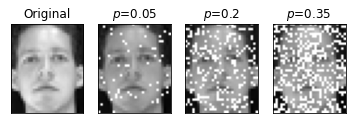

In [ ]:
X = X_orl
img_size = img_size_orl
p_s = [0.05, 0.2, 0.35]

images, labels = [], []
for i in range(3):
    X_noisy = random_noise(X, p=p_s[i])
    images.append(X_noisy[:, 0])
    labels.append("$p$=" + str(p_s[i]))

display_noise_images(X[:, 0], images, labels, img_size)

#### 4.1.2 Gaussian noise

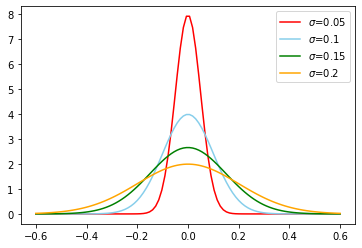

In [ ]:
mu = 0
sigmas = [0.05, 0.1, 0.15, 0.2]
colors = ['red', 'skyblue', 'green', 'orange']
x = np.linspace(mu - 3 * max(sigmas), mu + 3 * max(sigmas), 100)
for i in range(len(sigmas)):
    plt.plot(x, stats.norm.pdf(x, mu, sigmas[i]), color=colors[i], label="$\sigma$=" + str(sigmas[i]))
    plt.legend()
plt.show()


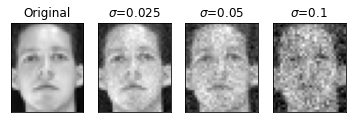

In [ ]:
X = X_orl
img_size = img_size_orl
sigmas = [0.025, 0.05, 0.1]
images = []
labels = []
for i in range(3):
    X_noisy = gaussian_noise(X, sigma=sigmas[i])
    images.append(X_noisy[:, 0])
    labels.append("$\sigma$=" + str(sigmas[i]))

display_noise_images(X[:, 0], images, labels, img_size)

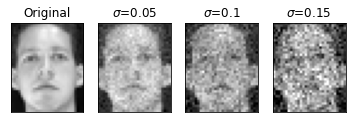

In [ ]:
X = X_orl
img_size = img_size_orl
sigmas = [0.05, 0.1, 0.15, 0.2]
images = []
labels = []
for i in range(3):
    X_noisy = gaussian_noise(X, sigma=sigmas[i])
    images.append(X_noisy[:, 0])
    labels.append("$\sigma$=" + str(sigmas[i]))

display_noise_images(X[:, 0], images, labels, img_size)

#### 4.1.3 Laplacian noise


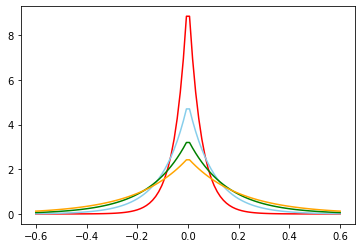

In [ ]:
mu = 0
b_s = [0.05, 0.1, 0.15, 0.2]
colors = ['red', 'skyblue', 'green', 'orange']
x = np.linspace(mu - 3 * max(b_s), mu + 3 * max(b_s), 100)
for i in range(len(b_s)):
    plt.plot(x, stats.laplace.pdf(x, mu, b_s[i]), color=colors[i])
plt.show()


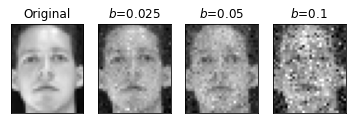

In [ ]:
X = X_orl
img_size = img_size_orl
b_s = [0.025, 0.05, 0.1]

images = []
labels = []
for i in range(len(b_s)):
    X_noisy = laplacian_noise(X, b=b_s[i])
    images.append(X_noisy[:, 0])
    labels.append("$b$=" + str(b_s[i]))

display_noise_images(X[:, 0], images, labels, img_size)

### 4.2 Number of Components vs Performance

In [ ]:
def no_components_experiment(X, Y, model: str, n_components, noise_model: tuple = ("None", -1), p=0.9):
    """
    Run specified NMF algorithms varying the number of components

    :param X: X data
    :param Y: Y data
    :param model: NMF algorithm to use
    :param noise_model: Type of noise to add to X and relevant noise parameter
    :param n_components: List of no. components to run experiment with
    :param p: Random sample p of data each time
    """
    # total number of iterations executed
    total_executed = 0

    result = defaultdict(list)
    for n in n_components:
        print("Using {} components".format(n))
        # Use only p of data
        X_sample, Y_sample = random_sample(X, Y, p=p)

        if noise_model[0] == "random":
            X_noisy = random_noise(X_sample, noise_model[1])
        elif noise_model[0] == "gaussian":
            X_noisy = gaussian_noise(X_sample, sigma=noise_model[1])
        elif noise_model[0] == "laplacian":
            X_noisy = laplacian_noise(X_sample, b=noise_model[1])
        else:
            # Add no noise
            X_noisy = X_sample

        # Do 10 runs
        rre_m, rre_std, acc_m, acc_std, nmi_m, nmi_std, executed = run_nmf_and_evaluate_multiple(X_sample,
                                                                                                 X_noisy,
                                                                                                 Y_sample,
                                                                                                 model,
                                                                                                 n_components=n,
                                                                                                 no_runs=10)
        result['rres'].append(rre_m)
        result['rre_sds'].append(rre_std)
        result['accs'].append(acc_m)
        result['acc_sds'].append(acc_std)
        result['nmis'].append(nmi_m)
        result['nmi_sds'].append(nmi_std)

        total_executed += executed
    result['iters_exec'] = total_executed
    return result

In [ ]:
results1 = dict()

#### 4.2.1 Exploration

In [ ]:
# L2-norm NMF, ORL Dataset, Gaussian noise with $\sigma = 0.025$
%%time
model = "l2"

noise_type = "gaussian"
noise_param = 0.025
dataset = "orl"
params = (10, 120, 10)
identifier = (model, noise_type, noise_param, dataset, 0.9, params)
n_components = np.arange(*params)
# Dictionary result
d = no_components_experiment(X_orl, Y_orl, model, n_components, (noise_type, noise_param))
results1[identifier] = d

Using 10 components
average number of iterations l2: 386
Using 20 components
average number of iterations l2: 377
Using 30 components
average number of iterations l2: 362
Using 40 components
average number of iterations l2: 346
Using 50 components
average number of iterations l2: 340
Using 60 components
average number of iterations l2: 323
Using 70 components
average number of iterations l2: 312
Using 80 components
average number of iterations l2: 303
Using 90 components
average number of iterations l2: 291
Using 100 components
average number of iterations l2: 286
Using 110 components
average number of iterations l2: 278
CPU times: user 12min 50s, sys: 2min 17s, total: 15min 7s
Wall time: 7min 44s


total number of iterations executed: 35890


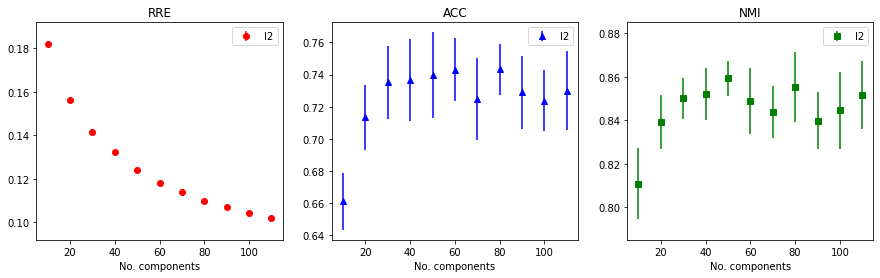

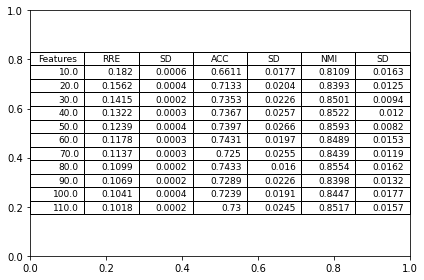

In [ ]:
params = (10, 120, 10)
n_components = np.arange(*params)
d = results1[("l2", "gaussian", 0.025, "orl", 0.9, params)]
print('total number of iterations executed: {}'.format(d['iters_exec']))

display_3_charts_with_sd(n_components, d, model, xlabel="No. components")
display_table(d, n_components, "Features")

In [ ]:
# L2-norm NMF, YALE Dataset, Gaussian noise with $\sigma = 0.025$
%%time
model = "l2"
noise_type = "gaussian"
noise_param = 0.025
dataset = "yale"
params = (10, 120, 10)
identifier = (model, noise_type, noise_param, dataset, 0.2, params)
n_components = np.arange(*params)
# Dictionary result
d = no_components_experiment(X_yale, Y_yale, model, n_components, (noise_type, noise_param), p=0.2)
results1[identifier] = d

Using 10 components
average number of iterations l2: 341
Using 20 components
average number of iterations l2: 393
Using 30 components
average number of iterations l2: 380
Using 40 components
average number of iterations l2: 371
Using 50 components
average number of iterations l2: 378
Using 60 components
average number of iterations l2: 367
Using 70 components
average number of iterations l2: 349
Using 80 components
average number of iterations l2: 362
Using 90 components
average number of iterations l2: 339
Using 100 components
average number of iterations l2: 332
Using 110 components
average number of iterations l2: 329


total number of iterations executed: 39465


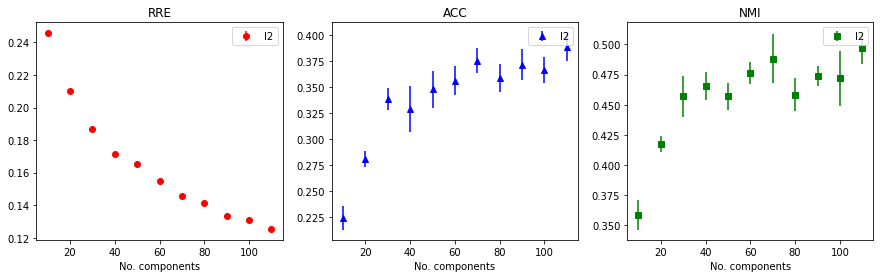

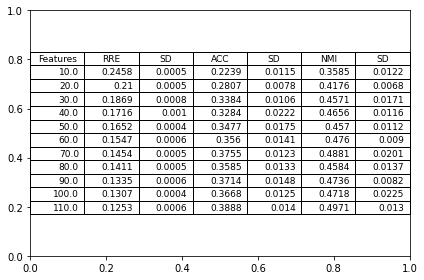

In [ ]:
params = (10, 120, 10)
n_components = np.arange(*params)
d = results1[("l2", "gaussian", 0.025, "yale", 0.2, params)]
print('total number of iterations executed: {}'.format(d['iters_exec']))

display_3_charts_with_sd(n_components, d, model, xlabel="No. components")
display_table(d, n_components, "Features")

#### 4.2.3 Run Everything

Time won't be measured as the %%time tag is designed for one jupyter cell

('l2', 'gaussian', 0.025, 'orl', 0.9, (10, 120, 10))
Using 10 components
average number of iterations l2: 361
Using 20 components
average number of iterations l2: 376
Using 30 components
average number of iterations l2: 352
Using 40 components
average number of iterations l2: 350
Using 50 components
average number of iterations l2: 338
Using 60 components
average number of iterations l2: 323
Using 70 components
average number of iterations l2: 314
Using 80 components
average number of iterations l2: 306
Using 90 components
average number of iterations l2: 293
Using 100 components
average number of iterations l2: 288
Using 110 components
average number of iterations l2: 278
total number of iterations executed: 35834
('l2', 'gaussian', 0.025, 'yale', 0.2, (10, 120, 10))
Using 10 components
average number of iterations l2: 385
Using 20 components
average number of iterations l2: 393
Using 30 components
average number of iterations l2: 392
Using 40 components
average number of iterations l

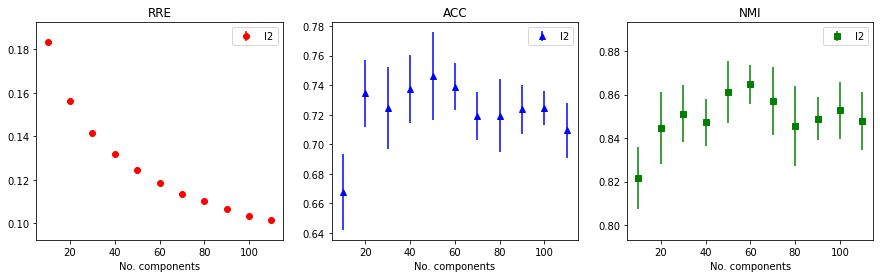

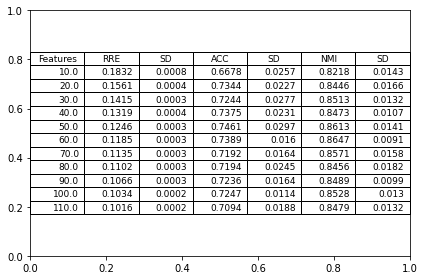

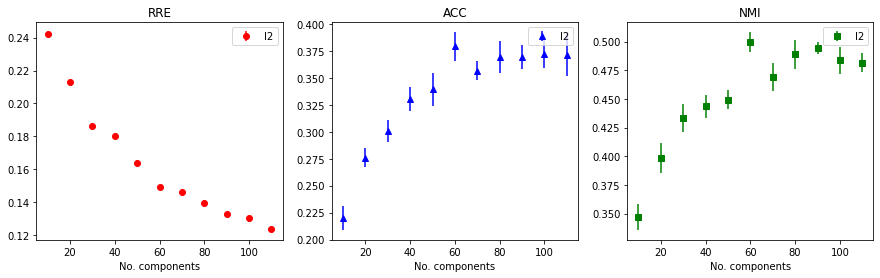

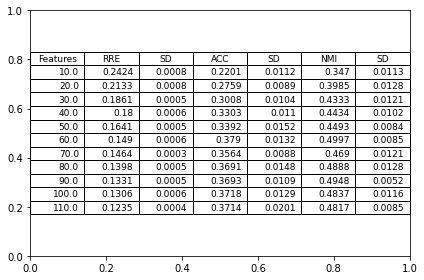

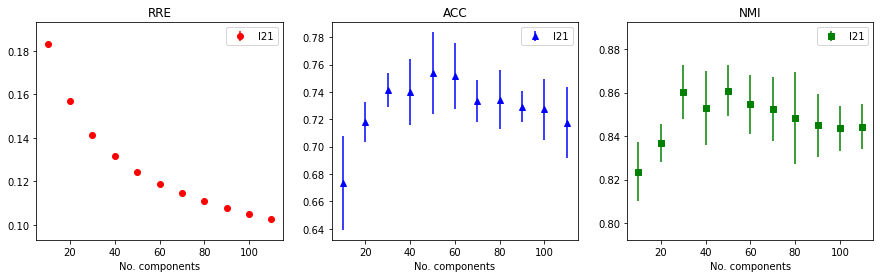

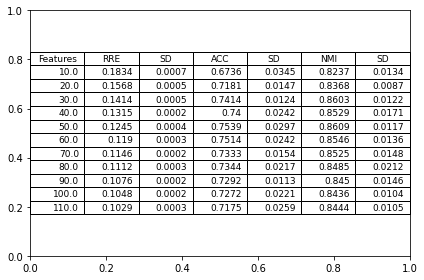

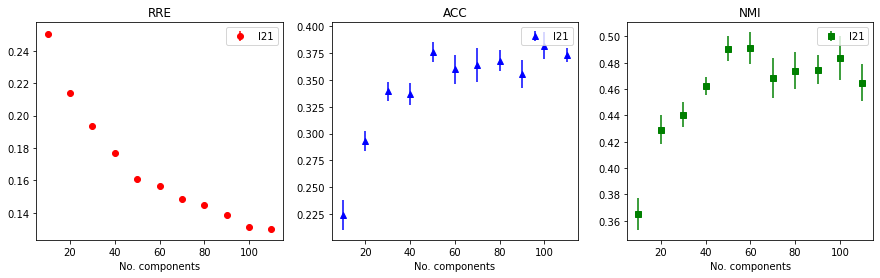

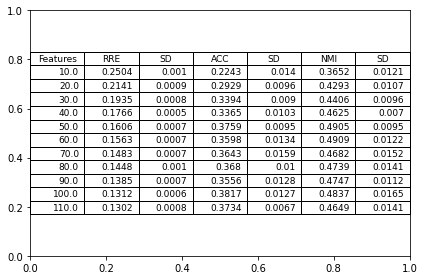

In [ ]:
stored_results = dict()
# each tuple represents one experiment
# (model, noise_type, noise_param, dataset, p, no_components_arange
# no_components_arange = (10, 120, 10) means we test from 10 to 120 and step size is 10
ids = [("l2", "gaussian", 0.025, "orl", 0.9, (10, 120, 10)),
       ("l2", "gaussian", 0.025, "yale", 0.2, (10, 120, 10)),
       ("l21", "gaussian", 0.025, "orl", 0.9, (10, 120, 10)),
       ("l21", "gaussian", 0.025, "yale", 0.2, (10, 120, 10))]

for id in ids:
    print(id)
    model = id[0]
    noise_type = id[1]
    noise_param = id[2]
    X = Xs[id[3]]
    Y = Ys[id[3]]
    p = id[4]
    n_components = np.arange(*id[5])

    d = no_components_experiment(X, Y, model, n_components, (noise_type, noise_param), p=p)
    display_3_charts_with_sd(n_components, d, model, xlabel="No. components")
    display_table(d, n_components, "Features")

    print('total number of iterations executed: {}'.format(d['iters_exec']))
    stored_results[id] = d

### 4.3 Noise Scale vs Performance


In [ ]:
def noise_paramters_experiment(X, Y, noise_type: str, parameters, n_components=100, p=0.9):
    """
    Given a noise model, run different NMF algorithms varying the noise parameter

    :param X: X data
    :param Y: Y data
    :param noise_type: Type of noise to add to X
    :param parameters: Paramters to run with
    :param n_components: Number of components to use, 100 by default
    :param p: Randomly sample p of data each time
    """
    models = ["l2", "l21"]
    result = defaultdict(lambda: defaultdict(list))
    total_executed = 0

    for param in parameters:
        print("Using noise parameter = {}".format(param))
        # Use only 90% of data
        X_sample, Y_sample = random_sample(X, Y)

        if noise_type == "random":
            X_noisy = random_noise(X_sample, param)
        elif noise_type == "gaussian":
            X_noisy = gaussian_noise(X_sample, sigma=param)
        elif noise_type == "laplacian":
            X_noisy = laplacian_noise(X_sample, b=param)
        else:
            print("Invalid noise type. Experiment not ran.")
            return

        for model in models:
            # Do 5 runs
            rre_m, rre_std, acc_m, acc_std, nmi_m, nmi_std, executed = run_nmf_and_evaluate_multiple(X_sample,
                                                                                                     X_noisy,
                                                                                                     Y_sample,
                                                                                                     model,
                                                                                                     n_components,
                                                                                                     no_runs=5)
            result[model]['rres'].append(rre_m)
            result[model]['rre_sds'].append(rre_std)
            result[model]['accs'].append(acc_m)
            result[model]['acc_sds'].append(acc_std)
            result[model]['nmis'].append(nmi_m)
            result[model]['nmi_sds'].append(nmi_std)

            total_executed += executed
    result['iters_exec'] = total_executed
    return result

In [ ]:
results2 = dict()

#### 4.3.1 Exploration

In [ ]:
# Experiment results on ORL dataset, 100 components, Laplacian noise in range [0, 0.2].
%%time
dataset = "orl"
n_components = 100
noise_type = "laplacian"
params = (0, 0.2, 10)
parameters = np.linspace(*params)
# Dictionary result
d = noise_paramters_experiment(X_orl, Y_orl, "laplacian", parameters)
identifier = (dataset, n_components, noise_type, params)
results2[identifier] = d

Using noise parameter = 0.0
average number of iterations l2: 282
l2
average number of iterations l21: 284
l21
Using noise parameter = 0.022222222222222223
average number of iterations l2: 287
l2
average number of iterations l21: 288
l21
Using noise parameter = 0.044444444444444446
average number of iterations l2: 304
l2
average number of iterations l21: 305
l21
Using noise parameter = 0.06666666666666667
average number of iterations l2: 333
l2
average number of iterations l21: 337
l21
Using noise parameter = 0.08888888888888889
average number of iterations l2: 378
l2
average number of iterations l21: 371
l21
Using noise parameter = 0.11111111111111112
average number of iterations l2: 399
l2
average number of iterations l21: 399
l21
Using noise parameter = 0.13333333333333333
average number of iterations l2: 399
l2
average number of iterations l21: 399
l21
Using noise parameter = 0.15555555555555556
average number of iterations l2: 399
l2
average number of iterations l21: 399
l21
Using 

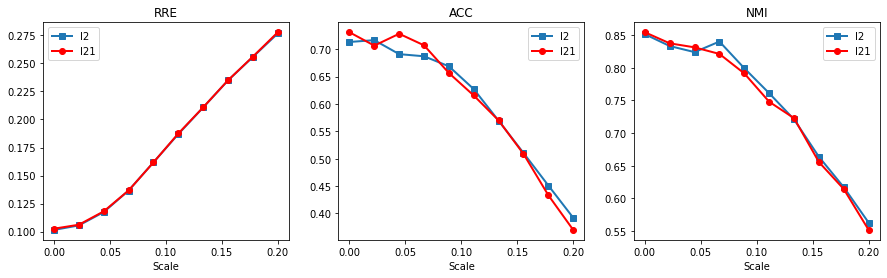

In [ ]:
params = (0, 0.2, 10)
parameters = np.linspace(*params)
id = ("orl", 100, "laplacian", params)
d = results2[id]
display_3_charts_without_sd(parameters, d, xlabel="Scale")

In [ ]:
# Experiment results on YALE dataset, 100 components, Laplacian noise in range [0, 0.2].
%%time
dataset = "yale"
n_components = 100
noise_type = "laplacian"
params = (0, 0.2, 10)
parameters = np.linspace(*params)
# Dictionary result
d = noise_paramters_experiment(X_yale, Y_yale, "laplacian", parameters, p=0.2)
identifier = (dataset, n_components, noise_type, params)
results2[identifier] = d

Using noise parameter = 0.0
average number of iterations l2: 192
average number of iterations l21: 195
Using noise parameter = 0.022222222222222223
average number of iterations l2: 196


KeyboardInterrupt: 

In [ ]:
params = (0, 0.2, 10)
parameters = np.linspace(*params)
id = ("yale", 100, "laplacian", params)
d = results2[id]
display_3_charts_without_sd(parameters, d, xlabel="Scale")

#### 4.3.3 Run everything


Using noise parameter = 0.0
average number of iterations l2: 282
average number of iterations l21: 283
Using noise parameter = 0.022222222222222223
average number of iterations l2: 289
average number of iterations l21: 286
Using noise parameter = 0.044444444444444446
average number of iterations l2: 304
average number of iterations l21: 305
Using noise parameter = 0.06666666666666667
average number of iterations l2: 333
average number of iterations l21: 336
Using noise parameter = 0.08888888888888889
average number of iterations l2: 373
average number of iterations l21: 377
Using noise parameter = 0.11111111111111112
average number of iterations l2: 399
average number of iterations l21: 399
Using noise parameter = 0.13333333333333333
average number of iterations l2: 399
average number of iterations l21: 399
Using noise parameter = 0.15555555555555556
average number of iterations l2: 399
average number of iterations l21: 399
Using noise parameter = 0.17777777777777778
average number of 

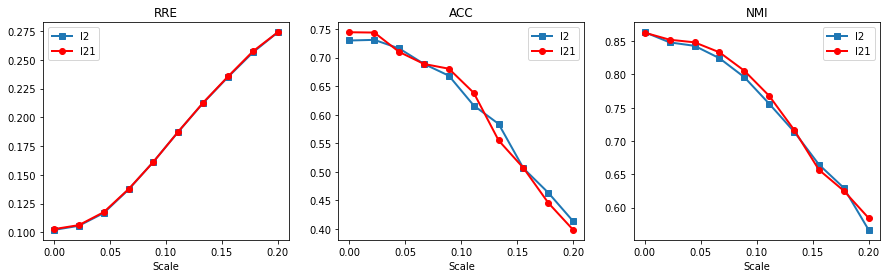

Using noise parameter = 0.0
average number of iterations l2: 192
average number of iterations l21: 194
Using noise parameter = 0.022222222222222223
average number of iterations l2: 193
average number of iterations l21: 192
Using noise parameter = 0.044444444444444446
average number of iterations l2: 192
average number of iterations l21: 195
Using noise parameter = 0.06666666666666667
average number of iterations l2: 192


In [ ]:
stored_results_noise = dict()
# each tuple represents an experiment
# (dataset, p, no_components, noise_type, noise_arange)
# noise_arange = (0, 0.2, 10) means we test 10 values from 0 to 0.2
ids = [('orl', 0.9, 100, "laplacian", (0, 0.2, 10)),
       ('yale', 0.2, 100, "laplacian", (0, 0.2, 10)),
       ('orl', 0.9, 100, "gaussian", (0, 0.2, 10)),
       ('yale', 0.2, 100, "gaussian", (0, 0.2, 10)),
       ('orl', 0.9, 100, "random", (0, 0.2, 10)),
       ('yale', 0.2, 100, "random", (0, 0.2, 10)),]

for id in ids:
    X = Xs[id[0]]
    Y = Ys[id[0]]
    p = id[1]
    n_components = id[2]
    noise_type = id[3]
    parameters = np.linspace(*id[4])
    d = noise_paramters_experiment(X, Y, noise_type, parameters, p=p)
    display_3_charts_without_sd(parameters, d, xlabel="Scale")

    stored_results_noise[id] = d

In [ ]:
for key in stored_results_noise:
    print(key)
    models = ['l2', 'l21']
    for m in models:
        d = stored_results_noise[m]
        parameters = np.linspace(*key[4])
        display_table(d, parameters, "noise level")